In [15]:
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv('data/intent-detection-train.csv')

In [17]:
# see an example of each intent

for intent in df['label'].unique():
    print(intent)
    print(df[df['label'] == intent].iloc[0]['text'])
    print()

translate
Pouvez-vous me dire comment dire «je ne parle pas beaucoup espagnol», en espagnol

travel_alert
La Corée du Nord a-t-elle des alertes de voyage que je devrais être conscientes

flight_status
Y a-t-il des nouvelles sur le vol DL123

lost_luggage
Localiser les bagages perdus de Flight America Airlines à O'Hare

travel_suggestion
Veuillez suggérer des activités touristiques amusantes à Tokyo

carry_on
Voulez-vous me faire part des restrictions de bagage à main pour American Airlines

book_hotel
Réservez-moi une chambre du 11 au 15 novembre à Cali

book_flight
Trouvez-moi des vols aller-retour de LAX vers SFOX

out_of_scope
Combien coûte des frais de découvert pour la banque



<Figure size 1500x1500 with 0 Axes>

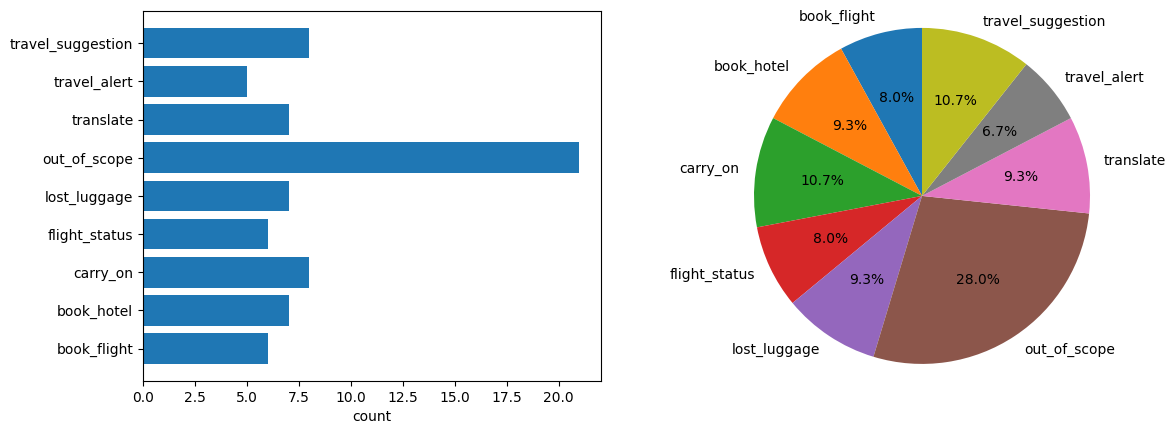

In [18]:
#Plot class distribution

plt.figure(figsize=(15,15))
fig, axs = plt.subplots(1,2)
plt.subplots_adjust(right = 1.7)
grouped = df.groupby("label").count().reset_index()
axs[0].barh(grouped["label"], grouped["text"])
axs[0].set_xlabel("count")
axs[1].pie(grouped["text"], labels=grouped["label"], startangle=90, autopct='%1.1f%%')
axs[1].axis('equal')
plt.show()

french, then faut choisir un model qui est good for french, CamemBERT

In [49]:
from openai import AzureOpenAI
from dotenv import load_dotenv
import os
import re
import ast


load_dotenv()

client = AzureOpenAI(
    azure_endpoint = os.getenv("AZURE_OPENAI_ENDPOINT"), 
    api_key=os.getenv("AZURE_OPENAI_API_KEY"),
    api_version=os.getenv("AZURE_OPENAI_API_VERSION"),
    azure_deployment=os.getenv("AZURE_OPENAI_DEPLOYMENT")
)


In [64]:
# Prompt système pour le contexte global
prompt_system = {
    "role": "system",
    "content": """
Tu es un assistant spécialisé dans la génération de données d'entraînement pour un projet de détection d'intention. Le but est de créer \
des phrases pour entraîner un modèle de classification d'intention pour un chatbot d’assistance dans le domaine du tourisme. \
Ce chatbot est destiné à une société de tourisme et doit être capable de classer les messages des utilisateurs en différentes \
intentions afin de répondre à leurs besoins liés aux voyages.

Voici la liste des intentions cibles :
1. `translate` : L’utilisateur souhaite traduire une phrase dans une autre langue pour faciliter la communication lors de ses voyages.
2. `travel_alert` : L’utilisateur demande si sa destination de voyage est concernée par une alerte ou restriction de sécurité.
3. `flight_status` : L’utilisateur souhaite obtenir des informations sur le statut de son vol (retard, annulation, etc.).
4. `lost_luggage` : L’utilisateur signale la perte de ses bagages lors d'un voyage.
5. `travel_suggestion` : L’utilisateur demande une recommandation de destination ou des suggestions de voyage.
6. `carry_on` : L’utilisateur souhaite obtenir des informations sur les règles de bagages à main pour son vol.
7. `book_hotel` : L’utilisateur souhaite réserver un hôtel pour son séjour.
8. `book_flight` : L’utilisateur souhaite réserver un vol vers une destination spécifique.
9. `out_of_scope` : L’utilisateur pose une question qui n’est pas liée aux services de voyage ou de tourisme proposés par la société \
(par exemple, des questions sur la météo locale ou des informations générales non liées aux voyages ni au tourisme).

Instructions de formatage des réponses :
Pour chaque phrase générée, respecte impérativement le format suivant :
- Chaque phrase doit être représentée sous forme d'un dictionnaire Python structuré comme suit : `{ "phrase": "Votre phrase ici", "label": "label_approprié" }`
- Assure-toi que chaque phrase soit adaptée au contexte touristique et formulée de manière naturelle et pertinente.
- Ne génère que la structure demandée `{ "phrase": ..., "label": ... }` pour chaque exemple, sans aucun texte additionnel ou explication.

Ton rôle est de générer des phrases naturelles, diversifiées et pertinentes pour chaque intention. Je fournirai des instructions spécifiques \
pour chaque intention individuellement.

"""
}

# Fonction pour générer des phrases pour une intention donnée
def generate_phrases_for_intent(intent_prompt):
    response = client.chat.completions.create(
        model="gpt-3.5-turbo", 
        messages=[
            prompt_system,  # Contexte global
            {"role": "user", "content": intent_prompt}  # Prompt utilisateur pour l'intention spécifique
        ],
        temperature=0.9,
        n=1,
        stop=None
    )
    
    # Extraire le texte de la réponse
    generated_text = response.choices[0].message.content.strip()
    return generated_text


In [65]:
liste_intentions = df['label'].unique()

phrases = []

for intent in liste_intentions:
    examples = df[df['label'] == intent]['text'].sample(5).tolist()

    formatted_examples = "\n".join(
        [f'{{ "text": "{example}", "label": "{intent}" }}' for example in examples]
    )

    intent_prompt = f"""Pour l’intention '{intent}', génère 80 phrases en respectant le format suivant :
    {{ "text" : "Phrase de l'utilisateur ici", "label" : "{intent}"}}

    Les phrases doivent être naturelles et pertinentes pour un contexte touristique, Après chaque phrase générée, fais un retour à la ligne pour une meilleure lisibilité.

    Voici des exemples de ce que nous attendons :
    {formatted_examples}

    Génère des phrases similaires en suivant ce format et en insérant un retour à la ligne après chaque phrase.
    """

    generated_phrases = generate_phrases_for_intent(intent_prompt)

    lines = generated_phrases.split("\n")

    for line in lines:
        # Vérifier si la ligne correspond au format d'un dictionnaire attendu
        if re.match(r'^\{ "text": ".+", "label": ".+" \}$', line.strip()):
            # Convertir la ligne en dictionnaire
            phrase_dict = ast.literal_eval(line.strip())
            # Ajouter le dictionnaire à la liste des données
            phrases.append(phrase_dict)


In [ ]:
pd.DataFrame(phrases).to_csv('intent-detection-phrases5.csv', index=False)

In [ ]:
# constructing the final dataset
df = pd.read_csv('data/intent-detection-train.csv')
df1 = pd.read_csv('data/intent-detection-phrases.csv')
df2 = pd.read_csv('data/intent-detection-phrases2.csv')
df3 = pd.read_csv('data/intent-detection-phrases3.csv')
df4 = pd.read_csv('data/intent-detection-phrases4.csv')
df5 = pd.read_csv('data/intent-detection-phrases5.csv')


df_final = pd.concat([df, df1, df2, df3, df4, df5], ignore_index=True)

# le deliminateur est ; dans les fichiers csv
df_final.to_csv('data/intent-detection-final.csv', index=False, sep=';')



Worked with MS Excel to see and remove duplicates automatically..

In [90]:
df_final = pd.read_csv('data/intent-detection-final.csv', sep=';')

<Figure size 1500x1500 with 0 Axes>

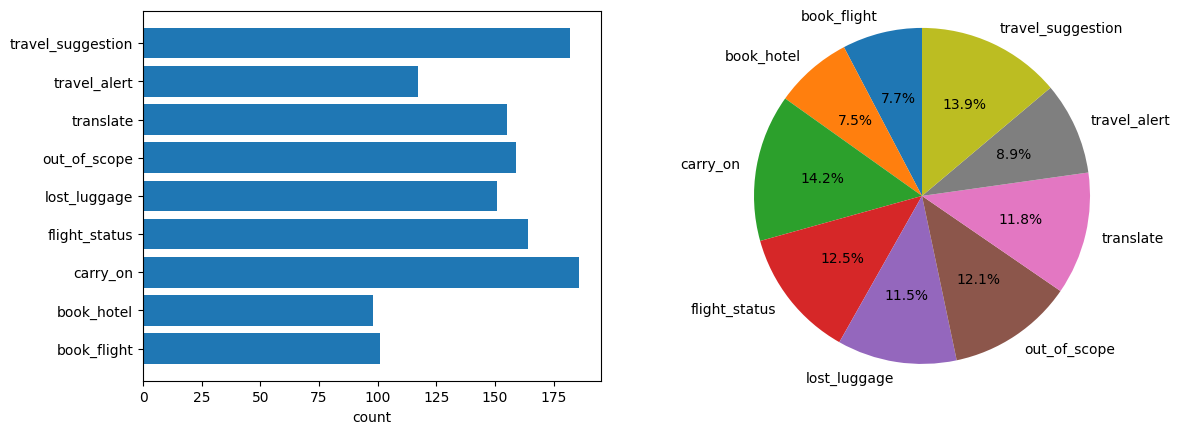

In [77]:
#Plot class distribution

plt.figure(figsize=(15,15))
fig, axs = plt.subplots(1,2)
plt.subplots_adjust(right = 1.7)
grouped = df_final.groupby("label").count().reset_index()
axs[0].barh(grouped["label"], grouped["text"])
axs[0].set_xlabel("count")
axs[1].pie(grouped["text"], labels=grouped["label"], startangle=90, autopct='%1.1f%%')
axs[1].axis('equal')
plt.show()

In [78]:
liste_intentions = ['travel_alert', 'book_hotel', 'book_flight']

phrases = []

for intent in liste_intentions:
    examples = df[df['label'] == intent]['text'].sample(5).tolist()

    formatted_examples = "\n".join(
        [f'{{ "text": "{example}", "label": "{intent}" }}' for example in examples]
    )

    intent_prompt = f"""Pour l’intention '{intent}', génère 40 phrases en respectant le format suivant :
    {{ "text" : "Phrase de l'utilisateur ici", "label" : "{intent}"}}

    Les phrases doivent être naturelles et pertinentes pour un contexte touristique, Après chaque phrase générée, fais un retour à la ligne pour une meilleure lisibilité.

    Voici des exemples de ce que nous attendons :
    {formatted_examples}

    Génère des phrases similaires en suivant ce format et en insérant un retour à la ligne après chaque phrase.
    """

    generated_phrases = generate_phrases_for_intent(intent_prompt)

    lines = generated_phrases.split("\n")

    for line in lines:
        # Vérifier si la ligne correspond au format d'un dictionnaire attendu
        if re.match(r'^\{ "text": ".+", "label": ".+" \}$', line.strip()):
            # Convertir la ligne en dictionnaire
            phrase_dict = ast.literal_eval(line.strip())
            # Ajouter le dictionnaire à la liste des données
            phrases.append(phrase_dict)


In [80]:
pd.DataFrame(phrases).to_csv('data/intent-detection-phrases6.csv', index=False)

df6 = pd.read_csv('data/intent-detection-phrases6.csv')

In [93]:
df_final = pd.concat([df_final, df6], ignore_index=True)

df_final.to_csv('data/intent-detection-final2.csv', index=False, sep=';')

In [88]:
df_final = pd.read_csv('data/intent-detection-final2.csv', sep=';')

<Figure size 1500x1500 with 0 Axes>

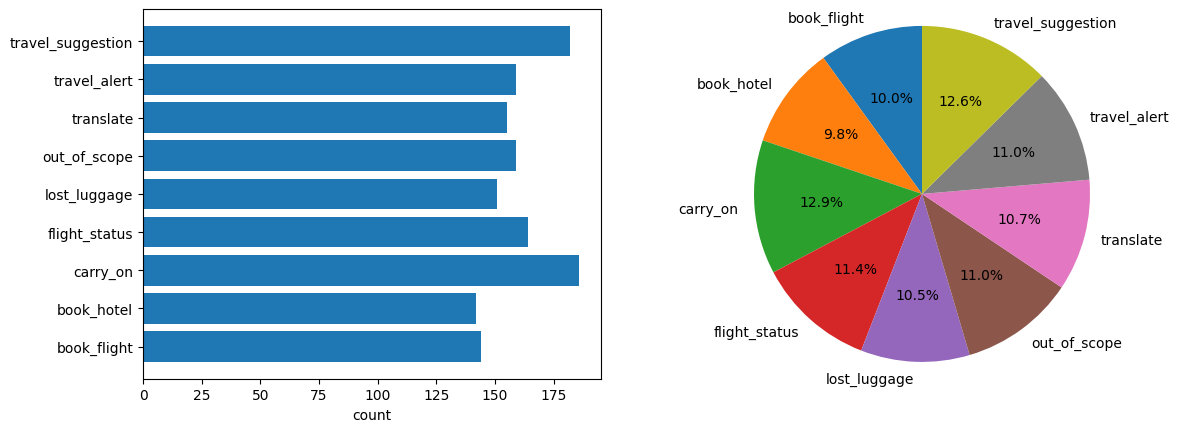

In [92]:
#Plot class distribution

plt.figure(figsize=(15,15))
fig, axs = plt.subplots(1,2)
plt.subplots_adjust(right = 1.7)
grouped = df_final.groupby("label").count().reset_index()
axs[0].barh(grouped["label"], grouped["text"])
axs[0].set_xlabel("count")
axs[1].pie(grouped["text"], labels=grouped["label"], startangle=90, autopct='%1.1f%%')
axs[1].axis('equal')
plt.show()

In [94]:
# Save the final dataset as excel file

df_final.to_excel('data/data.xlsx', index=False)

To test all the models on the same test set

In [ ]:
from sklearn.model_selection import train_test_split
# Diviser les données en ensembles d'entraînement et de test
train_data, test_data = train_test_split(df_final, test_size=0.2, stratify=df_final['label'])

# Enregistrer les ensembles d'entraînement et de test dans des fichiers CSV séparés
train_data.to_csv("data/train_data.csv", index=False, sep=';')
test_data.to_csv("data/test_data.csv", index=False, sep=';')